# Train Single Agent on Mountain Car

In [1]:
import gym
import pandas as pd

from vae import VAE, create_decoder, create_encoder
from transition_gru import TransitionGRU
from daif_agent import DAIFAgent
from prior_preferences_model import PriorPreferencesModel
from a2c import PolicyGradientNetwork, compute_discounted_cumulative_reward
from ddpg import *

In [2]:
from util import transform_observations, test_policy, habit_policy
from train_agent import train_single_agent

What does the agent do?
- The agent plans using a policy then executes that policy for 12 simulation timesteps, the first two actions of the policy are executed for 6 steps each

What data does it accumulate?
- It accumulates 12 observation actions pairs

How is it trained?
- VAE is trained to reproduce observations using the latent states
- Transition is trained by taking previous hidden state and previous latent state and trying to predict the next latent state


Online learning For all tasks, we initialize all the agents with random weights and learn online only. Training an agent for 150 epochs takes about 3 minutes on a single CPU core (Intel I7-4870HQ). In contrast, previous approaches using active inference [Ueltzhöffer, 2018, Tschantz et al., 2019, 2020] and policy gradient methods (e.g., [Liu et al., 2017]) use (offline) policy replay and typically need hours of GPU-accelerated compute while achieving similar convergence. To our knowledge, this is the first model-based RL method to learn online using neural network representations. This is afforded by the high sample efficiency of the FEEF, which directs exploration towards states that are uncertain for both the encoder and transition models.


Why this is true?

In [3]:
# Hide GPU from visible devices
tf.config.set_visible_devices([], 'GPU')

## Test with no prior model FEEF

In [4]:
pln_hrzn = 5
latent_dim = 2
obs_dim = 2

# make the VAE
enc = create_encoder(2, latent_dim, [20])
dec = create_decoder(latent_dim, 2, [20])
vae = VAE(enc, dec, latent_dim,  [0]*latent_dim, [0.3]*latent_dim, train_epochs=2, show_training=False)
vae.compile(optimizer=tf.keras.optimizers.Adam())

# make the TRANSITION
tran = TransitionGRU(latent_dim, 1, 2*pln_hrzn*latent_dim, 2, train_epochs=2, show_training=False)
tran.compile(optimizer=tf.keras.optimizers.Adam())

# make the PRIOR NET
prior_model = PriorPreferencesModel(latent_dim, output_dim=1, show_training=False, use_tanh_on_output=False)

# unscaled prior mean and prior stddev
prior_mean = [0.45, 0]
prior_stddev = [1, 1]

observation_max = np.array([0.6, 0.07])
observation_min = np.array([-1.2, -0.07])

# observation_noise_stddev = [0, 0]
observation_noise_stddev = [0.05, 0.05]

scaled_prior_mean = transform_observations(prior_mean, observation_max, observation_min, [0,0])  # no noise on prior

## Uncomment for using A2C

In [5]:
# make the HABIT ACTION NET
habit_net = PolicyGradientNetwork(latent_dim, 1, [16, 16], train_epochs=2, show_training=False)
habit_net.compile(optimizer=tf.keras.optimizers.Adam())

daifa = DAIFAgent(prior_model,
                           vae,
                           tran,
                           habit_net,
                           planning_horizon=pln_hrzn,
                           use_efe_extrinsic=True,
                           use_kl_intrinsic=True,
                           use_FEEF=False,
                           train_habit_net=True,
                           train_prior_model=True,
                           train_tran=True,
                           train_during_episode=True,
                           train_with_replay=True,
                           use_habit_policy=True,
                           habit_model_type="A2C",
                           uncertainty_tolerance=0.1,
                           min_rewards_needed_to_train_prior=-10,
                           prior_model_scaling_factor=1)

## Uncomment for using DDPG

In [6]:
# # # make the DDPG HABIT ACTION NET
# actor_model = get_actor(2, 1)
# critic_model = get_critic(2, 1)
# target_actor = get_actor(2, 1)
# target_critic = get_critic(2, 1)
#
# # Making the weights equal initially
# target_actor.set_weights(actor_model.get_weights())
# target_critic.set_weights(critic_model.get_weights())
# critic_optimizer = tf.keras.optimizers.Adam(0.0001)
# actor_optimizer = tf.keras.optimizers.Adam(0.00005)
# habit_net = BasicDDPG(actor_model, critic_model, target_actor, target_critic, tau=0.005, critic_optimizer=critic_optimizer, actor_optimizer=actor_optimizer)
#
#
# daifa = DAIFAgent(prior_model,
#                            vae,
#                            tran,
#                            habit_net,
#                            planning_horizon=pln_hrzn,
#                            use_efe_extrinsic=True,
#                            use_kl_intrinsic=True,
#                            use_FEEF=False,
#                            train_habit_net=True,
#                            train_prior_model=True,
#                            train_tran=True,
#                            train_during_episode=True,
#                            train_with_replay=True,
#                            use_habit_policy=True,
#                            habit_model_type="DDPG",
#                            uncertainty_tolerance=0.1,
#                            min_rewards_needed_to_train_prior=-10,
#                            prior_model_scaling_factor=1)

In [7]:
# train the agent on the env
env = gym.make('MountainCarContinuous-v0')
daifa, results_one = train_single_agent(env, daifa, observation_max, observation_min, observation_noise_stddev, num_episodes=60, render_env=False)

Episode 1


2022-10-19 12:26:12.525379: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


Instructions for updating:
`scale_identity_multiplier` is deprecated; please combine it into `scale_diag` directly instead.
Number of habit choices: 2
Number of actions total: 75
training on full data
Success in episode 1 at time step 448 with reward 92.90467716121393
Episode 2
Number of habit choices: 5
Number of actions total: 167
training on full data
No Success
Episode 3
Number of habit choices: 7
Number of actions total: 167
training on full data
No Success
Episode 4
Number of habit choices: 1
Number of actions total: 122
training on full data
Success in episode 4 at time step 730 with reward 89.20720985645785
Episode 5
Number of habit choices: 10
Number of actions total: 167
training on full data
No Success
Episode 6
Number of habit choices: 17
Number of actions total: 109
training on full data
Success in episode 6 at time step 652 with reward 91.88045334346792
Episode 7
Number of habit choices: 2
Number of actions total: 51
training on full data
Success in episode 7 at time step

In [8]:
p = habit_policy(daifa)
res = test_policy(env, p, observation_max, observation_min, observation_noise_stddev, 20, daifa.agent_time_ratio)
res

,reward,timesteps,num_actions
0,99.723082,498,83
1,99.716250,522,87
2,99.728707,336,56
3,99.779378,330,55
4,99.683068,504,84
5,99.736179,522,87
6,99.751778,414,69
7,99.712205,468,78
8,99.708471,498,83
9,99.738913,426,71


In [9]:
daifa.train_vae = False
daifa.model_vae.show_training = False

daifa.train_habit_net = True
daifa.train_after_exploring = True
daifa.use_fast_thinking = True
daifa.uncertainty_tolerance = 0.1

In [10]:
# train the agent on the env
env = gym.make('MountainCarContinuous-v0')
daifa, results_two = train_single_agent(env, daifa, observation_max, observation_min, observation_noise_stddev, num_episodes=90, render_env=False)

Episode 1
Number of habit choices: 3
Number of actions total: 14
training on full data
Success in episode 1 at time step 83 with reward 98.90270555807845
Episode 2
Number of habit choices: 4
Number of actions total: 26
training on full data
Success in episode 2 at time step 153 with reward 98.04720462934894
Episode 3
Number of habit choices: 12
Number of actions total: 28
training on full data
Success in episode 3 at time step 163 with reward 98.5187119396215
Episode 4
Number of habit choices: 13
Number of actions total: 27
training on full data
Success in episode 4 at time step 158 with reward 98.98440179547069
Episode 5
Number of habit choices: 16
Number of actions total: 29
training on full data
Success in episode 5 at time step 173 with reward 98.7866964257831
Episode 6
Number of habit choices: 10
Number of actions total: 44
training on full data
Success in episode 6 at time step 260 with reward 97.1033114197972
Episode 7
Number of habit choices: 13
Number of actions total: 26
trai

In [11]:
p = habit_policy(daifa)
res = test_policy(env, p, observation_max, observation_min, observation_noise_stddev, 20, daifa.agent_time_ratio)
res

,reward,timesteps,num_actions
0,99.240390,204,34
1,99.122402,168,28
2,98.959626,162,27
3,98.983720,162,27
4,99.178452,168,28
5,99.325392,186,31
6,99.195279,174,29
7,99.174323,162,27
8,99.190015,198,33
9,99.166602,168,28


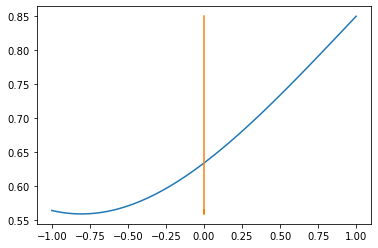

In [12]:
obs_pos = np.vstack([np.linspace(-1, 1, 100), np.zeros(100)]).T

latent_mean, _ , _ = daifa.model_vae.encoder(obs_pos)

utils = daifa.prior_model(latent_mean)
# print(utils)

plt.plot(obs_pos, utils)

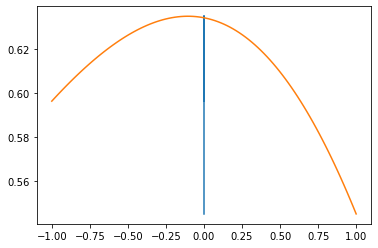

In [13]:
vel_pos = np.vstack([np.zeros(100), np.linspace(-1, 1, 100)]).T

latent_mean, _ , _ = daifa.model_vae.encoder(vel_pos)

utils = daifa.prior_model(latent_mean)
# print(utils)

plt.plot(vel_pos, utils)

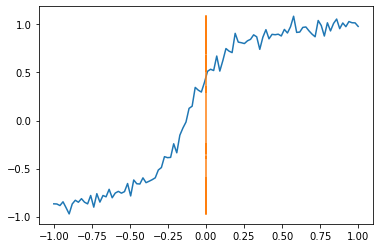

In [14]:
obs_pos = np.vstack([np.linspace(-1, 1, 100), np.zeros(100)]).T

latent_mean, _ , _ = daifa.model_vae.encoder(obs_pos)

# utils = daifa.habit_action_model.actor_model(latent_mean)
utils = daifa.select_habit_policy(latent_mean)
# print(utils)

plt.plot(obs_pos, utils)

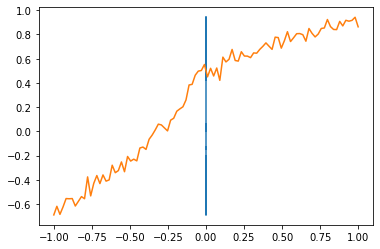

In [15]:
vel_pos = np.vstack([np.zeros(100), np.linspace(-1, 1, 100)]).T

latent_mean, _ , _ = daifa.model_vae.encoder(vel_pos)

# utils = daifa.habit_action_model.actor_model(latent_mean)
utils = daifa.select_habit_policy(latent_mean)
# print(utils)

plt.plot(vel_pos, utils)

In [16]:
env = gym.make('MountainCarContinuous-v0')
res = test_policy(env, p, observation_max, observation_min, observation_noise_stddev, 5, daifa.agent_time_ratio, show_env=True)
res

,reward,timesteps,num_actions
0,99.011801,162,27
1,98.891502,168,28
2,99.106953,156,26
3,99.028153,294,49
4,98.999495,162,27


In [17]:
full_results = pd.concat([results_one, results_two])
full_results = full_results.reset_index(drop=True)
full_results

,episode,success,sim_steps,VFE_post_run,noise_stddev,percent_use_fast_thinking,total_reward,agent_time_ratio
0,0,True,448,58.387444,"[0.05, 0.05]",0.026667,92.904677,6
1,1,False,999,53.060280,"[0.05, 0.05]",0.029940,-14.631364,6
2,2,False,999,33.161640,"[0.05, 0.05]",0.041916,-14.142330,6
3,3,True,730,57.308117,"[0.05, 0.05]",0.008197,89.207210,6
4,4,False,999,32.116009,"[0.05, 0.05]",0.059880,-14.109293,6
...,...,...,...,...,...,...,...,...
145,85,True,101,9.476604,"[0.05, 0.05]",0.176471,98.662095,6
146,86,True,157,8.395175,"[0.05, 0.05]",0.592593,98.664116,6
147,87,True,166,9.066815,"[0.05, 0.05]",0.357143,98.443511,6
148,88,True,170,10.281216,"[0.05, 0.05]",0.413793,98.270159,6


In [18]:
T = np.arange(len(full_results))

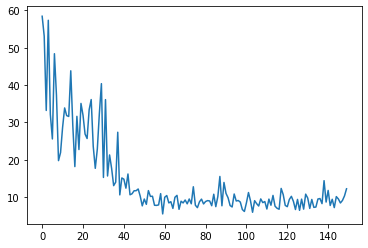

In [19]:
plt.plot(T, full_results.VFE_post_run)

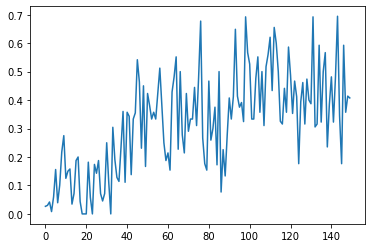

In [20]:
T = np.arange(len(full_results))
plt.plot(T, full_results.percent_use_fast_thinking)

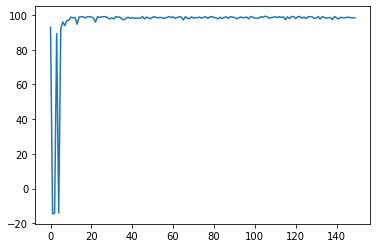

In [21]:
plt.plot(T, full_results.total_reward)

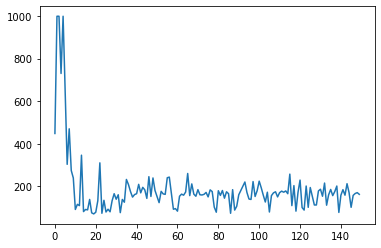

In [22]:
plt.plot(T, full_results.sim_steps)